In [1]:
import tensorflow as tf 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import tensorflow_datasets as tfds 

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools
from tqdm import tqdm 
import matplotlib.ticker as mticker 



e:\.conda\envs\coursera2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data, ds_info = tfds.load('fashion_mnist', split='train', with_info=True)
test_data = tfds.load("fashion_mnist",split="test")

In [3]:
class_names = ["T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

In [4]:

"""Formats our image to a specific format we can use for Deep Learning"""
def format_image(data):
    image = data["image"]
    image = tf.reshape(image,[-1])
    image = tf.cast(image, 'float32')
    image = image/255.0
    return image, data['label']



In [5]:
ds_info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='C:\\Users\\ayush\\tensorflow_datasets\\fashion_mnist\\3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
  

In [6]:
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

In [7]:
batch_size = 64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)
test = test_data.batch(batch_size)


In [15]:
# Model

def base_model():
    input = tf.keras.Input(shape=(784,), name='digits')
    x = tf.keras.layers.Dense(64, activation='relu', name ='dense1')(input)
    x = tf.keras.layers.Dense(64,activation='relu',name='Dense2')(x)
    x = tf.keras.layers.Dense(32,activation='relu',name='Dense3')(x)
    output = tf.keras.layers.Dense(10, activation='softmax', name='predictions')(x)
    model = tf.keras.Model(inputs=input, outputs=output)
    return model



In [9]:
optimizer = tf.keras.optimizers.Adam()
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy()

In [10]:
# Define the metrics
train_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()


In [11]:
# Setting the training core 
def apply_gradient(optimizer, model, x, y):
    with tf.GradientTape() as tape:
        logits = model(x)
        loss_value = loss_obj(y_true=y, y_pred=logits)
    
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    return logits, loss_value


In [12]:
# Setting the trining loop for one epoch
def train_data_for_one_epoch():
    losses = []
    progress_bar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}|{n_fmt}/{total_fmt} ')
    for step, (x_batch_train, y_batch_train) in enumerate(train):
        logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)
        losses.append(loss_value)

        train_accuracy_metric(y_batch_train,logits)
        progress_bar.set_description(f'Training loss for step {int(step)} :  {loss_value: .5f}' )
        progress_bar.update()
    return losses 

In [13]:
# Validation for val dataset
def perform_validation():
    
    losses = []
    for x_val, y_val in test:
        val_logits = model(x_val)
        val_loss = loss_obj(y_true = y_val, y_pred=val_logits)
        losses.append(val_loss)
        val_accuracy_metric(y_val, val_logits)
    return losses



In [17]:
# Final looping and setting

model = base_model()
epochs = 15

epoch_val_loss, epoch_train_loss = [], []

for epoch in range(epochs):
    print(f'Start of epoch {epoch}')

    losses_train = train_data_for_one_epoch()
    train_acc = train_accuracy_metric.result()

    losses_val = perform_validation()
    val_acc = val_accuracy_metric.result()

    losses_train_mean = np.mean(losses_train)
    losses_val_mean = np.mean(losses_val)
    epoch_val_loss.append(losses_val_mean)
    epoch_train_loss.append(losses_train_mean)

    print(f'\n Epoch: {epoch}\t Train Loss: {losses_train_mean} \t Val Loss: {losses_val_mean: .5f}')
    train_accuracy_metric.reset_states()
    val_accuracy_metric.reset_states()


Start of epoch 0


Training loss for step 937 :   0.58928: 100%|██████████|938/938 



 Epoch: 0	 Train Loss: 0.5199669599533081 	 Val Loss:  0.42923
Start of epoch 1


Training loss for step 937 :   0.22360: 100%|██████████|938/938 



 Epoch: 1	 Train Loss: 0.3789352774620056 	 Val Loss:  0.39073
Start of epoch 2


Training loss for step 937 :   0.24543: 100%|██████████|938/938 



 Epoch: 2	 Train Loss: 0.34339216351509094 	 Val Loss:  0.37827
Start of epoch 3


Training loss for step 937 :   0.14258: 100%|██████████|938/938 



 Epoch: 3	 Train Loss: 0.321819543838501 	 Val Loss:  0.36191
Start of epoch 4


Training loss for step 937 :   0.13744: 100%|██████████|938/938 



 Epoch: 4	 Train Loss: 0.30744481086730957 	 Val Loss:  0.36574
Start of epoch 5


Training loss for step 937 :   0.17231: 100%|██████████|938/938 



 Epoch: 5	 Train Loss: 0.2942090332508087 	 Val Loss:  0.38877
Start of epoch 6


Training loss for step 937 :   0.10560: 100%|██████████|938/938 



 Epoch: 6	 Train Loss: 0.28303009271621704 	 Val Loss:  0.36740
Start of epoch 7


Training loss for step 937 :   0.13151: 100%|██████████|938/938 



 Epoch: 7	 Train Loss: 0.27333927154541016 	 Val Loss:  0.36193
Start of epoch 8


Training loss for step 937 :   0.45918: 100%|██████████|938/938 



 Epoch: 8	 Train Loss: 0.26455506682395935 	 Val Loss:  0.35397
Start of epoch 9


Training loss for step 937 :   0.13862: 100%|██████████|938/938 



 Epoch: 9	 Train Loss: 0.25633543729782104 	 Val Loss:  0.35587
Start of epoch 10


Training loss for step 937 :   0.16690: 100%|██████████|938/938 



 Epoch: 10	 Train Loss: 0.24941129982471466 	 Val Loss:  0.34252
Start of epoch 11


Training loss for step 937 :   0.22134: 100%|██████████|938/938 



 Epoch: 11	 Train Loss: 0.24113106727600098 	 Val Loss:  0.34036
Start of epoch 12


Training loss for step 937 :   0.29626: 100%|██████████|938/938 



 Epoch: 12	 Train Loss: 0.23324918746948242 	 Val Loss:  0.35692
Start of epoch 13


Training loss for step 937 :   0.20819: 100%|██████████|938/938 



 Epoch: 13	 Train Loss: 0.23114582896232605 	 Val Loss:  0.36538
Start of epoch 14


Training loss for step 937 :   0.14725: 100%|██████████|938/938 



 Epoch: 14	 Train Loss: 0.22479742765426636 	 Val Loss:  0.35374


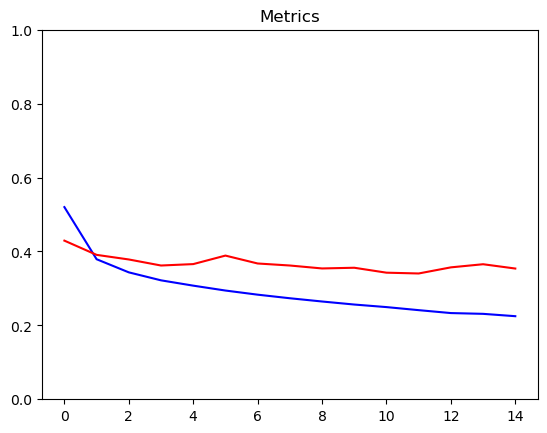

In [19]:
def plot_metrics(train_metric, val_metric,metric_name, title="Metrics", ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(train_metric, color='blue', label=metric_name)
    plt.plot(val_metric, color='red', label='val_'+metric_name)
    plt.show()
plot_metrics(epoch_train_loss,epoch_val_loss,"loss", ylim=1)

In [23]:
def display_images(image, prediction, labels, title, n):
    display_strings = [str(i) + "\n\n"+str(j) for i,j in zip(prediction, labels)]
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], display_strings)
    plt.grid(None)
    image = np.reshape(image, [n,28,28])
    image = np.swapaxes(image, 0,1)
    image = np.reshape(image,[28,28*n])
    plt.imshow(image)

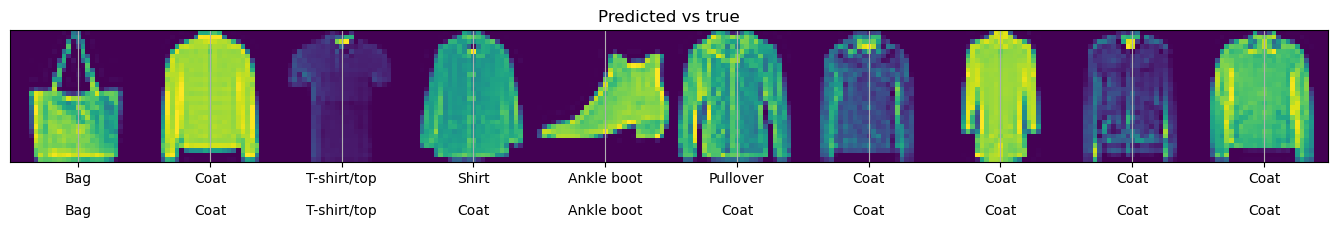

In [25]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [],[],[]

for x,y in test_inputs:
    y_pred = model(x)
    y_pred_batches = y_pred.numpy()
    y_true_batches = y.numpy()
    x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]

display_images(images_to_plot, y_pred_labels,y_true_labels,"Predicted vs true", 10)

